---
title: 6.1 深度卷积神经网络（AlexNet）
date: 2024-4-22 10:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#
<!--more-->
# 1 深度卷积神经网络（AlexNet）
- 与训练端到端（从像素到分类结果）系统的不同，经典机器学习的流水线看起来更像：
    1.获取一个数据集。
    2.根据光学、几何学、其他知识以及偶然的发现，手工对特征数据集进行预处理。
    3.通过标准的特征提取算法，如SIFT（尺度不变特征变换）和SURF（加速鲁棒特征）或其他手动调整的流水线来输入数据。
    4.将提取的特征输入分类器，以训练分类器。
## 1.1 学习表征
- 在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。在机器视觉中，最底层可能检测边缘、颜色和纹理。 
- 在网络的最底层，模型学习到了一些类似于传统滤波器的特征抽取器。
- AlexNet的更高层建立在这些底层表示的基础上，以表示更大的特征，如鼻子、眼睛等。而更高的层可以检测整个物体，如人、飞机等。最终的隐藏神经元可以学习图像的综合表示，从而使属于不同类别的数据易于区分。
- 深度卷积神经网络的突破归因于两个因素：
    - 数据
    - 硬件：图形处理器（Graphics Processing Unit，GPU）
## 1.2 AlexNet
- 从LeNet（左）到AlexNet（右）
![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/6_moden_conv/1_AlexNet/1.png)
![](img/deeplearning/code/pytorch/6_moden_conv/1_AlexNet/1.png)
- AlexNet和LeNet的设计理念非常相似，但也存在显著差异。
    1. AlexNet比相对较小的LeNet5要深得多。
    2. AlexNet使用ReLU而不是sigmoid作为其激活函数。
### 1.2.1 模型设计
- AlexNet的第一层，卷积窗口是11×11。因为ImageNet中绝大多数图像的宽和高比MNIST图像的多10倍以上，所以需要一个更大的卷积窗口来捕获目标。
- 第二层中的卷积窗口减小到5×5，然后是3×3。此外，在第一、第二和第五个卷积层之后，加入窗口大小为3×3、步幅为2的最大池化层。
- AlexNet的卷积通道数目是LeNet的10倍。
- 最后一个卷积层后有两个全连接层，分别有4096个输出。
### 1.2.2 激活函数
- ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。
- 当使用不同的初始化方法时，ReLU激活函数使训练模型更加容易。
- 当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。相反，ReLU激活函数在正区间的梯度总是1。因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。
### 1.2.3 容量控制和预处理
- AlexNet通过暂退法控制全连接层的模型复杂度，而LeNet只使用了权重衰减。
- 为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁剪、变色。这使得模型更加健壮，更大的样本量有效地减少了过拟合。

In [1]:
import torch
from torch import nn
from d2l import  torch as d2l

net = nn.Sequential(
    # 用11*11的更大窗口捕捉对象
    # 步幅为4，以减少输出的高度和宽度
    # 输出通道的数量比LeNet大数倍
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用padding=2来使输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口
    # 除了最后的卷积层， 输出通道的数量进一步增加
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以类别数为10，而非论文中的1000
    nn.Linear(4096, 10)
)

- 构造一个(1,244,244)的单通道数据，来观察每一层输出的形状。

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## 1.3 读取数据集
- 选取Fashion-MNIST数据集（28x28）。我们需要将图像大小调整到224x224。

In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## 1.4 训练AlexNet
- 与LeNet相比，这里使用更小的学习率，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。

KeyboardInterrupt: 

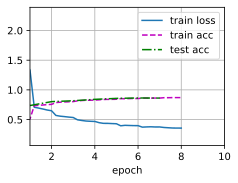

In [4]:
import os
os.environ["kmp_DUPLICATE_LIB_OK"] = "TRUE"
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())